In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')

In [2]:
from sys import path
path.append('..')
from convexcontrol.main import ControllerR2
from convexcontrol.resources import PVSysR2, BatteryR2, DiscreteR2

In [3]:
def convert_TCL_con(solar_data):    
    horizon = len(solar_data)     
    T_ = horizon // 2
    assert T_ == 288 # 5min interval 
    # first-day 
    solar_day1_cum = solar_data[0:T_].cumsum()
    solar_day1_mean = (solar_day1_cum).mean()
    # 
    TCL_day1_points = np.where( (solar_day1_cum < 1.01*solar_day1_mean) & (solar_day1_cum > 0.01*solar_day1_mean), 
                          1, solar_day1_cum)
    
    TCL_day1_points = np.where((TCL_day1_points < solar_day1_cum.max()) & (TCL_day1_points >= 1.0*solar_day1_mean), 
                          2, TCL_day1_points)
    TCL_day1_points = np.where((TCL_day1_points < 1) | (TCL_day1_points >= 1.0*solar_day1_mean),
                               0, TCL_day1_points)
    TCL_day1_points = TCL_day1_points.astype(np.int)
    # second day
    solar_day2_cum = solar_data[T_:].cumsum()
    solar_day2_mean = (solar_day2_cum).mean()
    
    TCL_day2_points = np.where((solar_day2_cum < 0.9*solar_day2_mean), 0, solar_day2_cum)
    TCL_day2_points = np.where((TCL_day2_points < solar_day2_cum.max()) & (TCL_day2_points >= 0.9*solar_day2_mean), 1, TCL_day2_points) 
    TCL_day2_points = np.where((TCL_day2_points >= solar_day2_mean), 0, TCL_day2_points)
    TCL_day2_points = TCL_day2_points.astype(np.int) 
    # 
    TCL_points = np.append(TCL_day1_points, TCL_day2_points)    
    # mask 0-1  
    TCL_points_mask = np.tile(np.concatenate((np.zeros(10), np.ones(10))), 576//20)
    TCL_points_mask = np.concatenate((TCL_points_mask, np.zeros(16)))
    TCL_points_w_duty = TCL_points_mask * TCL_points
    TCL_points_w_duty = np.array(TCL_points_w_duty,dtype=int)   
    
    return TCL_points_w_duty

In [4]:
# load data
Data1 = np.load('../data/VPP_data.npz')
real_agg = Data1['real_agg']
imag_agg = Data1['imag_agg']
SOCmax = Data1['SOCmax']
battmin = Data1['battmin']
battmax = Data1['battmax']
PV_inv_max = Data1['PV_inv_max']
Q = Data1['Q']
Q = Q.flatten()/12
Q = Q/SOCmax

Data2 = np.load('../data/other.npz')
solar = Data2['solar']
solar = np.r_[solar.flatten(), 0]
TCL_points_w_duty = convert_TCL_con(solar[:-1])
solar += 1e-7

agg_point = np.vstack((real_agg,imag_agg))

## Prioritize Optimal Setpoint Tracking

In [5]:
discrete_load_parameter = 1

In [6]:
# define constants
mu = 100

# define resources
pv1 = PVSysR2('pv1', Cpv=10, data=solar, pmax=PV_inv_max)
batt1 = BatteryR2('batt1', Cb=10, Cbl=0, pmin=battmin, pmax=battmax, initial_SoC=0., target_SoC=Q, capacity=SOCmax, eff=.95,
                 tstep=5./60)

points=np.array([[0, 0], [-.7,-.1], [-1.5, -.5], [-2, -1]])
#points=np.array([[0, 0], [-10,-5], [-20, -10]])
disc1 = DiscreteR2('disc1', points=points, desired=TCL_points_w_duty, Cdisc=discrete_load_parameter, t_lock=2)

# make controller
contr = ControllerR2(mu=mu)

# add resources
contr.addResource(pv1)
contr.addResource(batt1)
contr.addResource(disc1)

In [7]:
dim, T = agg_point.shape
print('resource names: ',contr.resource_names)
print('total time horizon: ', T)

('resource names: ', ['pv1', 'batt1', 'disc1'])
('total time horizon: ', 576)


In [8]:
start_time = time()
contr.runSimulation(agg_point, solver='MOSEK')
print('total comp time: {:.2f} seconds'.format(time() - start_time))

total comp time: 16.84 seconds


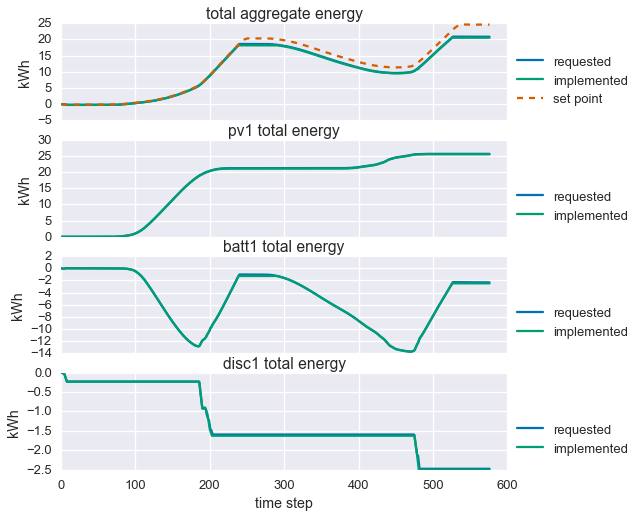

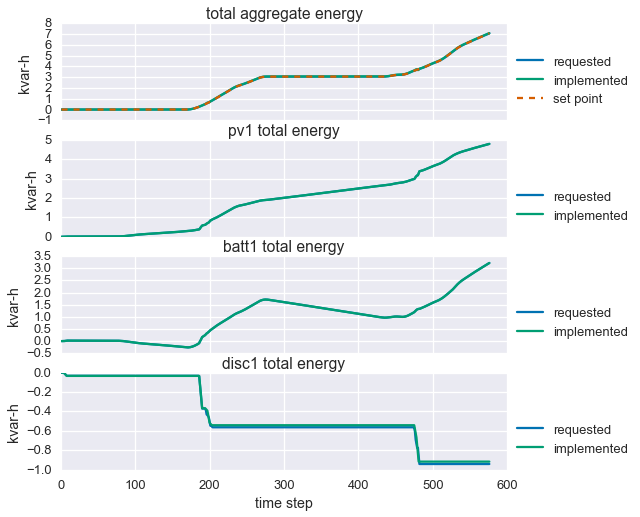

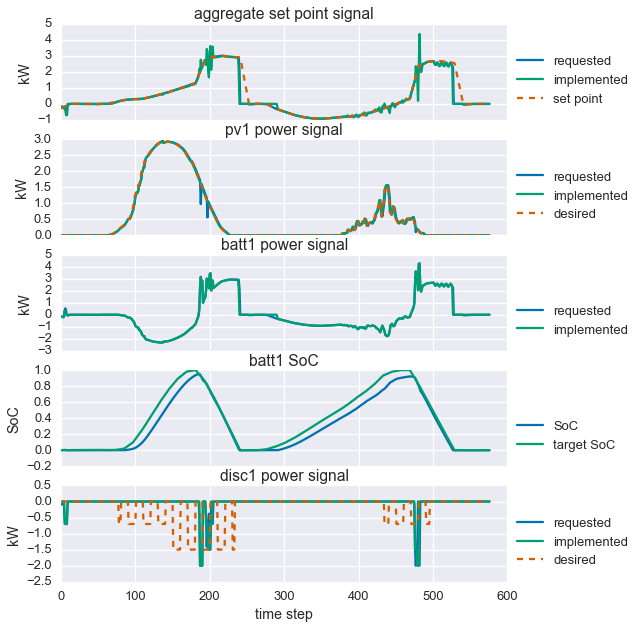

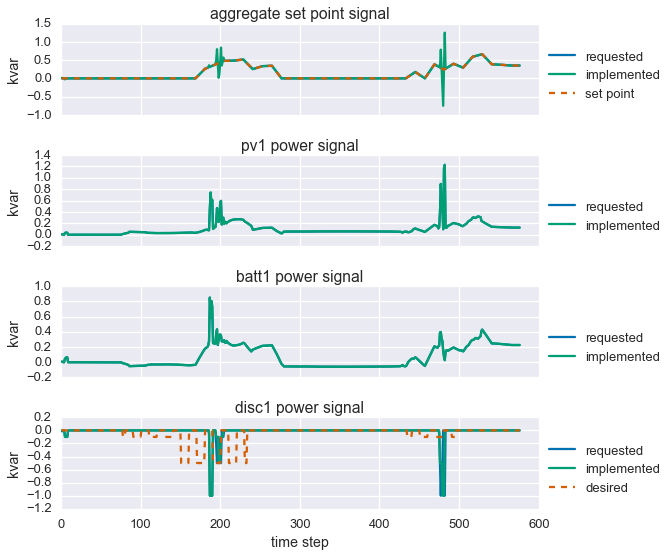

In [9]:
_ = contr.plotReqImpTotalEnergy(select='real')
_ = contr.plotReqImpTotalEnergy(select='reactive')
_ = contr.plotReqImpPower(select='real')
_ = contr.plotReqImpPower(select='reactive')
plt.tight_layout()
plt.show()

## Prioritize Discrete Load

In [10]:
discrete_load_parameter = 100

In [11]:
# define constants
mu = 100

# define resources
pv1 = PVSysR2('pv1', Cpv=10, data=solar, pmax=PV_inv_max)
batt1 = BatteryR2('batt1', Cb=10, Cbl=0, pmin=battmin, pmax=battmax, initial_SoC=0., target_SoC=Q, capacity=SOCmax, eff=.95,
                 tstep=5./60)

points=np.array([[0, 0], [-.7,-.1], [-1.5, -.5], [-2, -1]])
#points=np.array([[0, 0], [-10,-5], [-20, -10]])
disc1 = DiscreteR2('disc1', points=points, desired=TCL_points_w_duty, Cdisc=discrete_load_parameter, t_lock=2)

# make controller
contr = ControllerR2(mu=mu)

# add resources
contr.addResource(pv1)
contr.addResource(batt1)
contr.addResource(disc1)

In [12]:
dim, T = agg_point.shape
print('resource names: ',contr.resource_names)
print('total time horizon: ', T)

('resource names: ', ['pv1', 'batt1', 'disc1'])
('total time horizon: ', 576)


In [13]:
start_time = time()
contr.runSimulation(agg_point, solver='MOSEK')
print('total comp time: {:.2f} seconds'.format(time() - start_time))

total comp time: 16.82 seconds


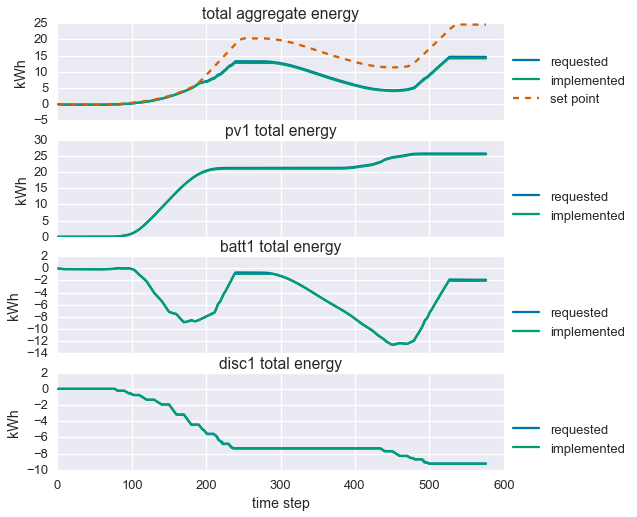

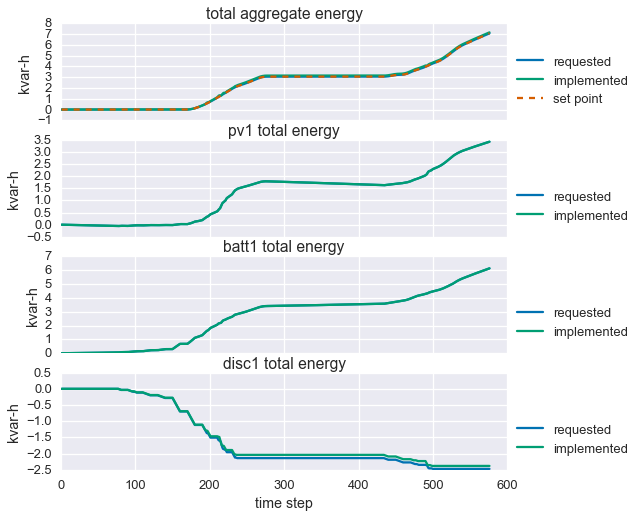

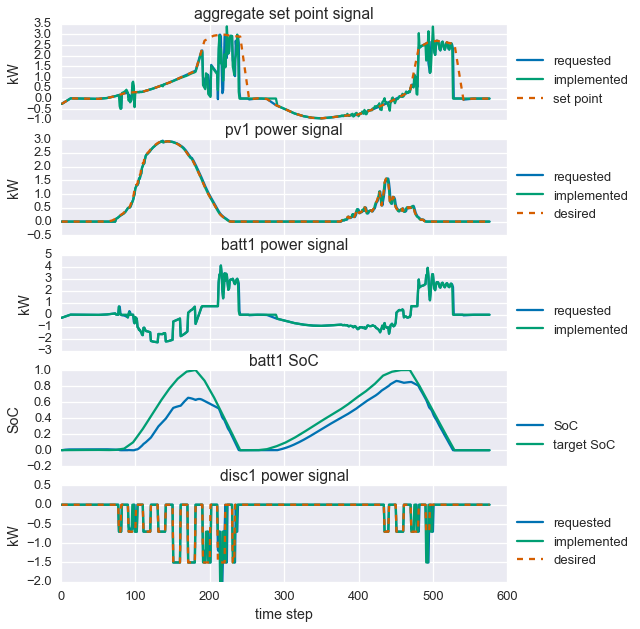

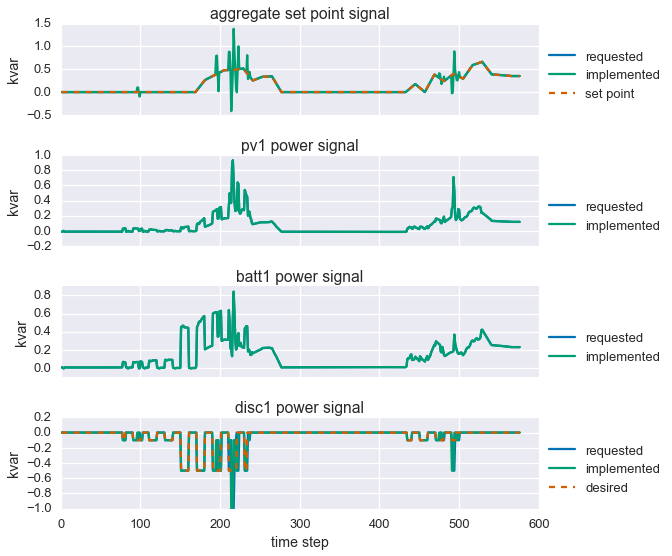

In [14]:
_ = contr.plotReqImpTotalEnergy(select='real')
_ = contr.plotReqImpTotalEnergy(select='reactive')
_ = contr.plotReqImpPower(select='real')
_ = contr.plotReqImpPower(select='reactive')
plt.tight_layout()
plt.show()